# Sea Animals Classification

### Team Members
 
- **Kshitij Yerande - 40194579**
- **Siddhartha Jha - 40201472**

### Problem Statement
The goal of the project is to analyze the performance of the various machine learning approaches to solve image classification problem of classifying sea animals into 9 categories Corals, Crabs, Penguin, Sea Urchins, Seahorse, Seal, Sharks, Starfish,Turtle_Tortoise.

### Dataset
The dataset is retrieved from kaggle. 

Link: https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste 

### Evaluation metrics

1. Accuracy: It is the most intuitive performance measure, and it is simply the ratio of correctly predicted observation to the total observations.
2. Precision: It is the ratio of the correctly predicted positive observations.
3. Recall: It is the ratio of correctly predicted positive observations to all observations in actual class.
4. F-score: It is the weighted average of precision and recall.

### Solution approaches

- Custom-CNN model: CNN architecture desined from scratch
- ResNet50 (Pre-trained) : Pretrained weights of ImageNet dataset used to train last layer on our dataset.
- SVM with HOG features(histogram of gradients) : HOG feature extracted and trained using SVM
- SVM with SIFT features: SIFT features extracted and trained using SVM

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, vgg16_bn
import torchvision.transforms as transforms


from torch.utils.data import random_split, SubsetRandomSampler, DataLoader,Subset, WeightedRandomSampler
from torch.optim import Adam

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torchviz import make_dot
import cv2

In [2]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CONSTANTS
DATASET_DIR = 'data/archive'
NUM_CLASSES = 9 # no of classes in the garbage dataset
BATCH_SIZE = 500 # for dataloader

cpu


### Data Preprocessing - Applying Transformations

In [3]:
# Resize images and normalize pixel values before passing it to the model
transformations = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

dataset = ImageFolder(DATASET_DIR, transform = transformations)

CLASSES = dataset.class_to_idx.keys()
TEST_CLASSES = dataset.class_to_idx.keys()
print('Total data',len(dataset))
print('Classes')
display(dataset.class_to_idx)

Total data 5944
Classes


{'Corals': 0,
 'Crabs': 1,
 'Penguin': 2,
 'Sea Urchins': 3,
 'Seahorse': 4,
 'Seal': 5,
 'Sharks': 6,
 'Starfish': 7,
 'Turtle_Tortoise': 8}

### Visualizing Data

Image sampled from class 0 - "Corals"


<Figure size 1400x700 with 0 Axes>

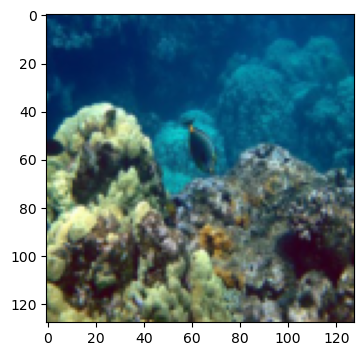

<Figure size 1400x700 with 0 Axes>

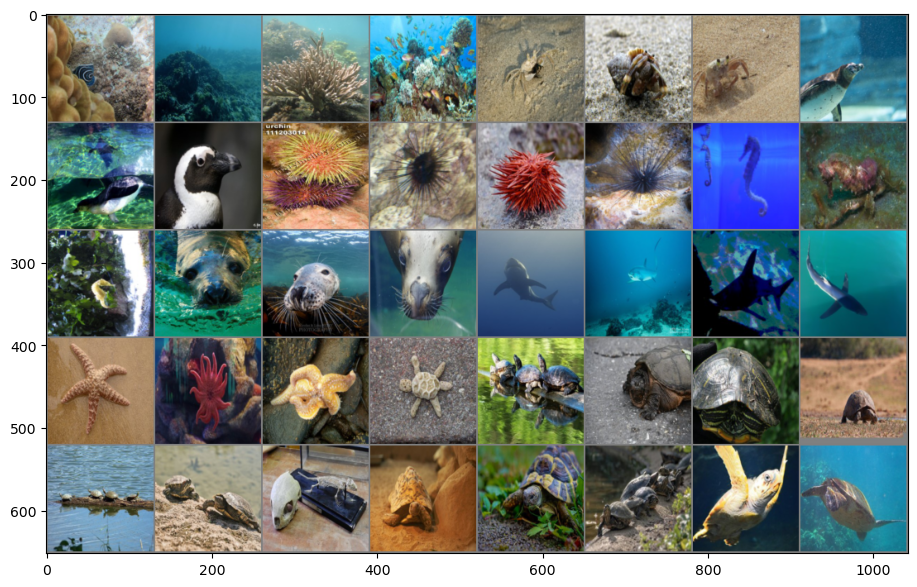

In [4]:
# utility method to print class label(s) and show image(s) of a row in the dataset
def imshow(image):
    plt.figure(figsize=(14,7))
    if not isinstance(image,torch.Tensor):
        plt.figure(figsize=(4,4))
        print(f'Image sampled from class {image[1]} - "{dataset.classes[image[1]]}"')
        npimg = np.array(image[0])
    else:
        plt.figure(figsize=(14,7))
        npimg = image.numpy()
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(dataset[10])
imshow(make_grid([dataset[idx][0] for idx in range(1,len(dataset),150)]))

In [6]:
all_idxs = np.arange(len(dataset))

# perform a 70/30 train-test split
train_idxs, test_idxs = train_test_split(all_idxs, test_size=0.3,stratify=dataset.targets, random_state=0)

# get the train and test set targets/labels
train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]

# set the test set's dataloader
test_set_loader = DataLoader(Subset(dataset, test_idxs), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print('train dataset',len(train_idxs))
print('test dataset',len(test_idxs))

train dataset 4160
test dataset 1784


### Balancing Training Data

In [7]:
# Perform oversampling of training data to make the dataset balanced
unique, count = np.unique(train_labels,return_counts=True)
print("Unique Labels:",len(unique))

class_weights = [np.sum(count) / c for c in count]
print("Class Weights:",class_weights)

#Assign weight to each sample
example_weights = [class_weights[e] for e in train_labels]
sampler = WeightedRandomSampler(example_weights,len(train_labels))
train_sampled_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

Unique Labels: 9
Class Weights: [11.885714285714286, 11.919770773638968, 12.344213649851632, 10.271604938271604, 12.417910447761194, 14.344827586206897, 10.072639225181598, 11.919770773638968, 3.123123123123123]


### Visualising Data Distribution - After OverSampling

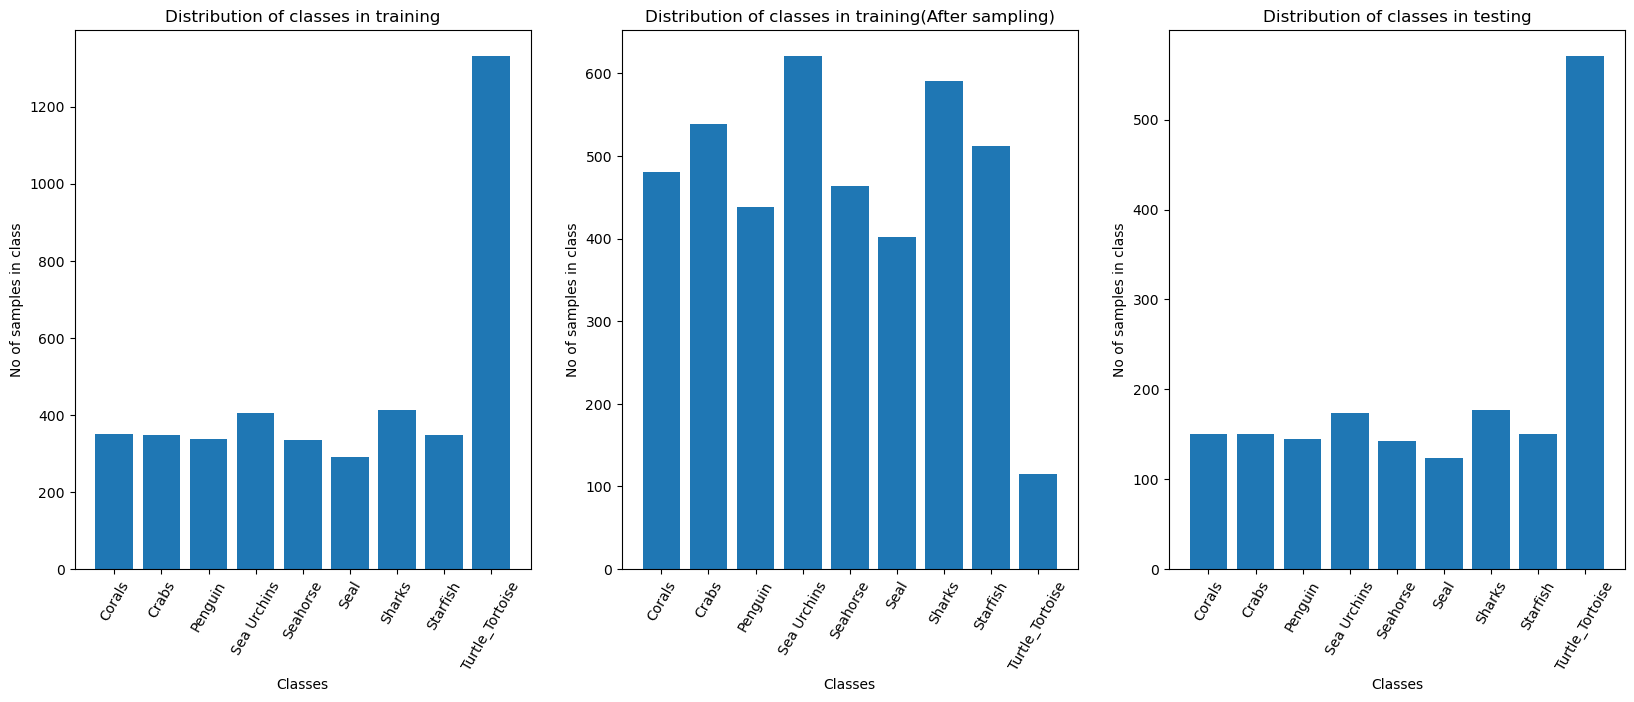

In [8]:
# Plot the distribution of classes in train and test sets
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())

plt.subplot(1,3,2)
plt.title('Distribution of classes in training(After sampling)')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
temp_labels=[]
for data,labels in train_sampled_dataloader:
    for c in labels.numpy():
        temp_labels.append(c)

sampled_train_label = Counter(temp_labels)
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
plt.bar(sampled_train_label.keys(), sampled_train_label.values())


plt.subplot(1,3,3)
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values());

### CNN Model Architectures:

#### Custom-CNN Model

Custom CNN model with 6 layers: 3 convolution layers and 3 linear layers. The first two convolution layers have a pooling layer and all 3 convolution layers uses batch normalization for training. ReLU activation function is used in all layers.

- 1<sup>st</sup> layer: uses convolution on 128x128 image with kernel size 11x11 depth 16 with zero padding followed by pooling layer of size 3x3 and stride 2
- 2<sup>nd</sup> layer: input of previous layer with depth 32 annd kernel size 7x7 with zero padding followed by pooling layer of size 3x3 and stride 2  
- 3<sup>rd</sup> layer: input of previous layer with depth 32 annd kernel size 3x3 with zero padding
- 4<sup>th</sup>,5<sup>th</sup>,6<sup>th</sup> layer: dense layer with output 256 -> 128 -> 9

<img src="https://raw.githubusercontent.com/Kshitij13579/Sea-Animals-Classification/main/customcnn.png?token=GHSAT0AAAAAACAJ5OWTPJ3EI4FTOYH7KT5MZBAUO7A" width=500 height=500 alt="Alternative text" />


#### ResNet50 Model

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer).

The 50-layer ResNet architecture includes the following elements, as shown in the table below:

- A 7×7 kernel convolution alongside 64 other kernels with a 2-sized stride.
- A max pooling layer with a 2-sized stride.
- 9 more layers—3×3,64 kernel convolution, another with 1×1,64 kernels, and a third with 1×1,256 kernels. These 3 layers are repeated 3 times. 
- 12 more layers with 1×1,128 kernels, 3×3,128 kernels, and 1×1,512 kernels, iterated 4 times.
- 18 more layers with 1×1,256 cores, and 2 cores 3×3,256 and 1×1,1024, iterated 6 times.
- 9 more layers with 1×1,512 cores, 3×3,512 cores, and 1×1,2048 cores iterated 3 times.
(up to this point the network has 50 layers)

- Average pooling, followed by a fully connected layer with 1000 nodes, using the softmax activation function.


<img src="https://raw.githubusercontent.com/Kshitij13579/Sea-Animals-Classification/main/resnet50.png?token=GHSAT0AAAAAACAJ5OWS5MAH7SMACTAQHGDEZBAUK4Q" alt="Alternative text" />

In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=11, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16928, 256),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
                nn.Linear(256, 128),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(128, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = resnet50(pretrained=True)
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
            
        self.nn.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, NUM_CLASSES))
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.nn(x))

### Methods for Evaluation of Model

In [9]:
@torch.no_grad()
def evaluate_model(model,loader):
    model.to('cpu')
    # set model to evaluation mode before evaluation
    model.eval()
    predictions = torch.tensor([])
    targets = torch.tensor([])

    for _, (images, labels) in enumerate(loader):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    return conf_matrix,[accuracy, f1, recall, precision]

def pretty_print_metrics(metrics):
    print('-- TEST SET METRICS --')
    print(f'Accuracy: {metrics[0]:.3f}%\nF-score: {metrics[1]:.3f}\nRecall: {metrics[2]:.3f}\nPrecision: {metrics[3]:.3f}')

def run_testing(model_to_test):
    model =None
    if model_to_test=="CustomCNN":
        model = CustomCNN()
    if model_to_test=="ResNet":
        model = ResNet()
    model.load_state_dict(torch.load(f'models/{model_to_test}-model.pt'),strict=False)
    model_to_test_conf_mat, model_to_test_metrics = evaluate_model(model, test_set_loader)
    pretty_print_metrics(model_to_test_metrics)
    plot_cm(np.array(model_to_test_conf_mat), CLASSES)

### Plotting Utilities

In [10]:
# Utility method to plot the confusion matrix over k-folds
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix")
    else:
        print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

# Utility method to plot both accuracy vs num epochs and loss vs num epochs
def plot_training_metrics(training_metrics_df):
    fig, ax = plt.subplots(2, figsize=(20,10))

    ax[0].set_xlabel('Number of epochs')
    ax[1].set_xlabel('Number of epochs')
    ax[0].set_ylabel('Training accuracy %')
    ax[1].set_ylabel('Training loss')
    
    ax[0].set_title('Training Accuracy vs Number of Epochs')
    ax[1].set_title('Training Loss vs Number of Epochs')
    ax[0].plot(training_metrics_df.epoch.values, training_metrics_df.accuracy.values)
    ax[1].plot(training_metrics_df.epoch.values, training_metrics_df.loss.values)

### Method for training model

In [11]:
# the actual training loop given a model, data loader, optimizer
def training_loop(model, train_loader, optimizer, total_step,name):
    epoch_metrics = []

    for epoch in range(NUM_EPOCHS):
        loss_val = 0.0
        acc_val = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            loss_val = loss.item()
            acc_val = (correct / total) * 100
            
            epoch_metrics.append({'epoch':epoch + (i/total_step),'loss':loss_val, 'accuracy':acc_val})
            
            print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')

    torch.save(model.state_dict(), f'models/{name}-model.pt')
    return epoch_metrics

In [12]:
def train(model,save):
    epoch_metrics_df = pd.DataFrame(columns=['epoch','loss','accuracy'])
    model.to(device)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    # run training
    epoch_metrics = training_loop(model, train_sampled_dataloader, optimizer, len(train_sampled_dataloader),save)
    epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)
    epoch_metrics_df.to_pickle(f'metric/{save}-metric.pkl')
    return epoch_metrics_df

### Training Data using ResNet50(Pre-Trained) Model

In [13]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
LOSS_FN = nn.CrossEntropyLoss()

#epoch_metrics_df =train(ResNet(),'ResNet')

C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\kshit\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Step [1/9], Loss: 2.2047, Accuracy: 6.00
Epoch [1/30], Step [2/9], Loss: 2.0781, Accuracy: 23.00
Epoch [1/30], Step [3/9], Loss: 1.9713, Accuracy: 52.80
Epoch [1/30], Step [4/9], Loss: 1.8485, Accuracy: 72.20
Epoch [1/30], Step [5/9], Loss: 1.7793, Accuracy: 79.80
Epoch [1/30], Step [6/9], Loss: 1.7183, Accuracy: 83.00
Epoch [1/30], Step [7/9], Loss: 1.6814, Accuracy: 79.80
Epoch [1/30], Step [8/9], Loss: 1.6469, Accuracy: 84.00
Epoch [1/30], Step [9/9], Loss: 1.6468, Accuracy: 81.88
Epoch [2/30], Step [1/9], Loss: 1.6117, Accuracy: 84.00
Epoch [2/30], Step [2/9], Loss: 1.6169, Accuracy: 82.60
Epoch [2/30], Step [3/9], Loss: 1.5873, Accuracy: 85.40
Epoch [2/30], Step [4/9], Loss: 1.5663, Accuracy: 86.00
Epoch [2/30], Step [5/9], Loss: 1.5539, Accuracy: 85.40
Epoch [2/30], Step [6/9], Loss: 1.5434, Accuracy: 86.20
Epoch [2/30], Step [7/9], Loss: 1.5850, Accuracy: 81.80
Epoch [2/30], Step [8/9], Loss: 1.5503, Accuracy: 85.80
Epoch [2/30], Step [9/9], Loss: 1.5506, Accuracy:

Epoch [17/30], Step [3/9], Loss: 1.4411, Accuracy: 92.80
Epoch [17/30], Step [4/9], Loss: 1.4649, Accuracy: 88.80
Epoch [17/30], Step [5/9], Loss: 1.4666, Accuracy: 89.20
Epoch [17/30], Step [6/9], Loss: 1.4571, Accuracy: 89.20
Epoch [17/30], Step [7/9], Loss: 1.4555, Accuracy: 90.00
Epoch [17/30], Step [8/9], Loss: 1.4573, Accuracy: 89.60
Epoch [17/30], Step [9/9], Loss: 1.4698, Accuracy: 88.75
Epoch [18/30], Step [1/9], Loss: 1.4602, Accuracy: 90.60
Epoch [18/30], Step [2/9], Loss: 1.4505, Accuracy: 91.60
Epoch [18/30], Step [3/9], Loss: 1.4311, Accuracy: 94.40
Epoch [18/30], Step [4/9], Loss: 1.4645, Accuracy: 89.20
Epoch [18/30], Step [5/9], Loss: 1.4433, Accuracy: 91.20
Epoch [18/30], Step [6/9], Loss: 1.4359, Accuracy: 92.80
Epoch [18/30], Step [7/9], Loss: 1.4485, Accuracy: 91.40
Epoch [18/30], Step [8/9], Loss: 1.4482, Accuracy: 89.80
Epoch [18/30], Step [9/9], Loss: 1.4486, Accuracy: 91.25
Epoch [19/30], Step [1/9], Loss: 1.4424, Accuracy: 91.20
Epoch [19/30], Step [2/9], Loss

C:\Users\kshit\AppData\Local\Temp\ipykernel_12700\60527815.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)


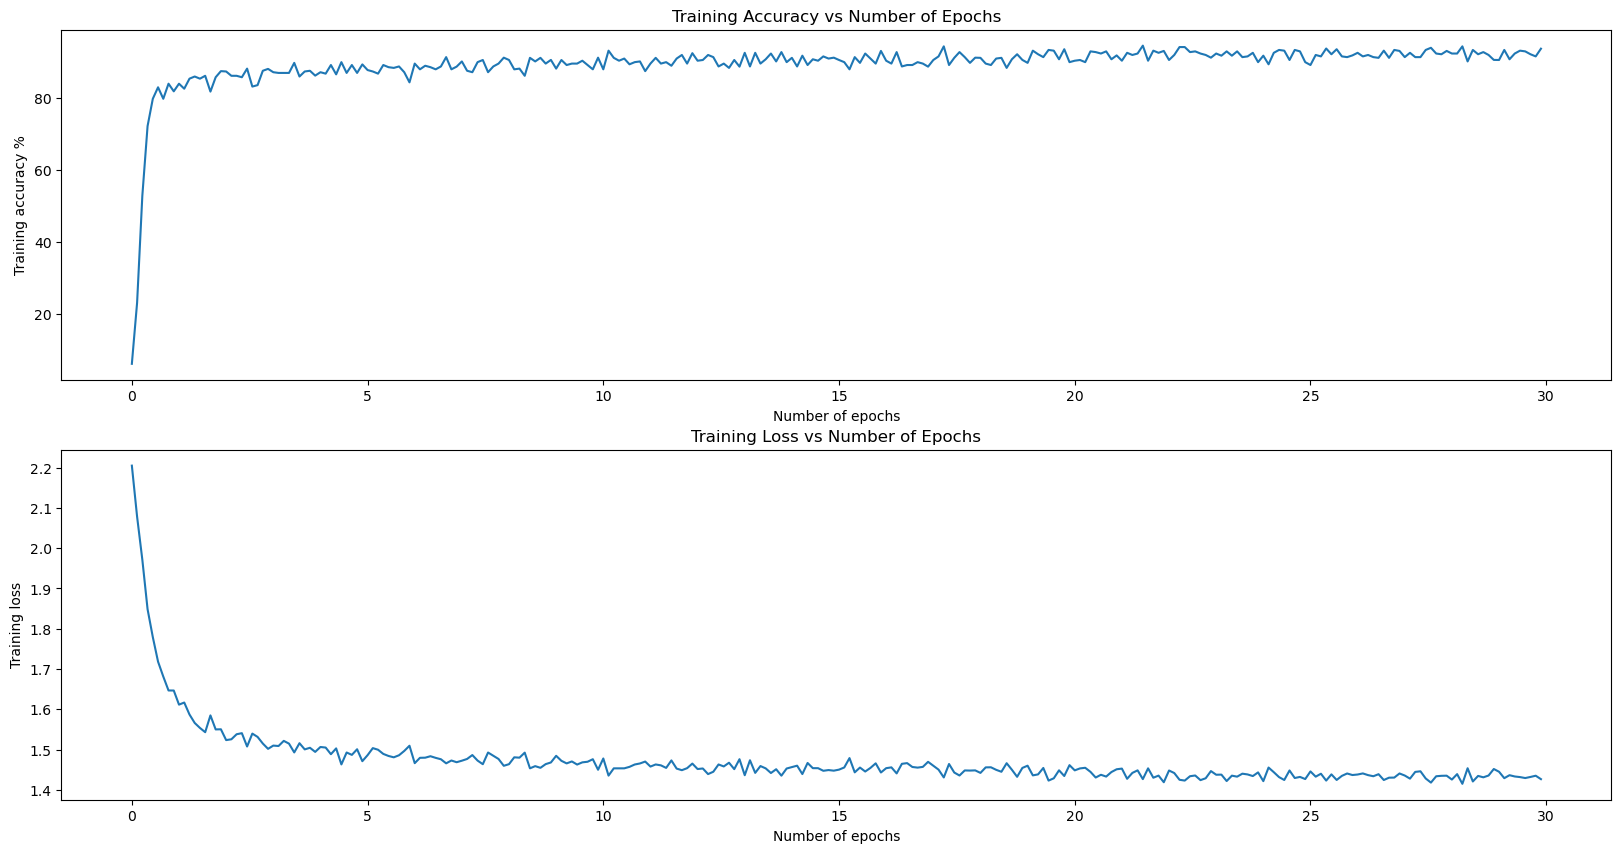

In [14]:
#plot_training_metrics(pd.read_pickle("metric/ResNet-metric.pkl"))

C:\Users\kshit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-- TEST SET METRICS --
Accuracy: 64.400%
F-score: 0.692
Recall: 0.844
Precision: 0.595
Confusion matrix


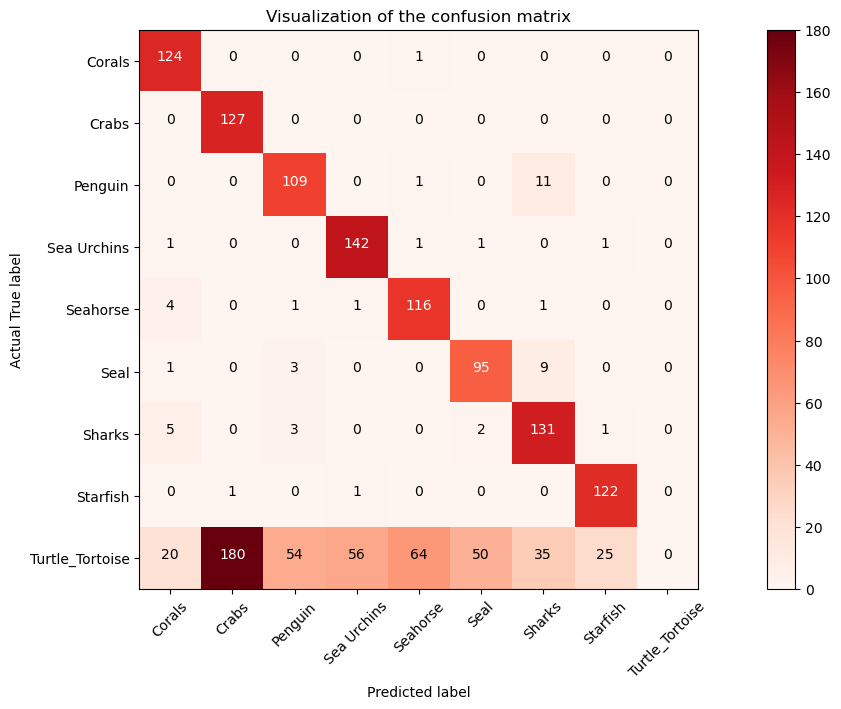

In [12]:
#run_testing('ResNet')

### Training Data using Custom-CNN Model

In [16]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
LOSS_FN = nn.CrossEntropyLoss()

#epoch_metrics_df =train(CustomCNN(),'CustomCNN')

Epoch [1/50], Step [1/9], Loss: 2.2140, Accuracy: 10.20
Epoch [1/50], Step [2/9], Loss: 2.0662, Accuracy: 25.00
Epoch [1/50], Step [3/9], Loss: 1.9624, Accuracy: 28.00
Epoch [1/50], Step [4/9], Loss: 1.7703, Accuracy: 29.80
Epoch [1/50], Step [5/9], Loss: 1.7156, Accuracy: 35.20
Epoch [1/50], Step [6/9], Loss: 1.6282, Accuracy: 34.80
Epoch [1/50], Step [7/9], Loss: 1.6701, Accuracy: 40.40
Epoch [1/50], Step [8/9], Loss: 1.7080, Accuracy: 38.80
Epoch [1/50], Step [9/9], Loss: 1.4456, Accuracy: 45.62
Epoch [2/50], Step [1/9], Loss: 1.6052, Accuracy: 42.20
Epoch [2/50], Step [2/9], Loss: 1.6097, Accuracy: 41.80
Epoch [2/50], Step [3/9], Loss: 1.4320, Accuracy: 47.00
Epoch [2/50], Step [4/9], Loss: 1.4692, Accuracy: 46.20
Epoch [2/50], Step [5/9], Loss: 1.4983, Accuracy: 47.00
Epoch [2/50], Step [6/9], Loss: 1.3997, Accuracy: 50.20
Epoch [2/50], Step [7/9], Loss: 1.4175, Accuracy: 47.00
Epoch [2/50], Step [8/9], Loss: 1.3806, Accuracy: 48.20
Epoch [2/50], Step [9/9], Loss: 1.4577, Accuracy

Epoch [17/50], Step [3/9], Loss: 0.5993, Accuracy: 79.00
Epoch [17/50], Step [4/9], Loss: 0.5890, Accuracy: 80.20
Epoch [17/50], Step [5/9], Loss: 0.5256, Accuracy: 82.20
Epoch [17/50], Step [6/9], Loss: 0.5090, Accuracy: 84.00
Epoch [17/50], Step [7/9], Loss: 0.5047, Accuracy: 82.60
Epoch [17/50], Step [8/9], Loss: 0.5203, Accuracy: 82.00
Epoch [17/50], Step [9/9], Loss: 0.6111, Accuracy: 75.00
Epoch [18/50], Step [1/9], Loss: 0.6240, Accuracy: 78.20
Epoch [18/50], Step [2/9], Loss: 0.5213, Accuracy: 80.80
Epoch [18/50], Step [3/9], Loss: 0.5812, Accuracy: 80.40
Epoch [18/50], Step [4/9], Loss: 0.5289, Accuracy: 83.20
Epoch [18/50], Step [5/9], Loss: 0.5179, Accuracy: 83.40
Epoch [18/50], Step [6/9], Loss: 0.5259, Accuracy: 82.20
Epoch [18/50], Step [7/9], Loss: 0.5047, Accuracy: 82.20
Epoch [18/50], Step [8/9], Loss: 0.4451, Accuracy: 85.40
Epoch [18/50], Step [9/9], Loss: 0.4670, Accuracy: 76.88
Epoch [19/50], Step [1/9], Loss: 0.4692, Accuracy: 84.20
Epoch [19/50], Step [2/9], Loss

Epoch [33/50], Step [3/9], Loss: 0.2154, Accuracy: 93.20
Epoch [33/50], Step [4/9], Loss: 0.2438, Accuracy: 90.80
Epoch [33/50], Step [5/9], Loss: 0.2177, Accuracy: 91.80
Epoch [33/50], Step [6/9], Loss: 0.2153, Accuracy: 92.60
Epoch [33/50], Step [7/9], Loss: 0.2409, Accuracy: 92.20
Epoch [33/50], Step [8/9], Loss: 0.2556, Accuracy: 90.80
Epoch [33/50], Step [9/9], Loss: 0.3090, Accuracy: 90.00
Epoch [34/50], Step [1/9], Loss: 0.2070, Accuracy: 92.20
Epoch [34/50], Step [2/9], Loss: 0.2471, Accuracy: 92.80
Epoch [34/50], Step [3/9], Loss: 0.2172, Accuracy: 93.00
Epoch [34/50], Step [4/9], Loss: 0.1983, Accuracy: 93.00
Epoch [34/50], Step [5/9], Loss: 0.2450, Accuracy: 93.00
Epoch [34/50], Step [6/9], Loss: 0.2344, Accuracy: 91.80
Epoch [34/50], Step [7/9], Loss: 0.2227, Accuracy: 93.60
Epoch [34/50], Step [8/9], Loss: 0.1987, Accuracy: 94.40
Epoch [34/50], Step [9/9], Loss: 0.1515, Accuracy: 94.38
Epoch [35/50], Step [1/9], Loss: 0.2165, Accuracy: 92.80
Epoch [35/50], Step [2/9], Loss

Epoch [49/50], Step [3/9], Loss: 0.1136, Accuracy: 96.20
Epoch [49/50], Step [4/9], Loss: 0.0889, Accuracy: 97.60
Epoch [49/50], Step [5/9], Loss: 0.1014, Accuracy: 96.80
Epoch [49/50], Step [6/9], Loss: 0.0980, Accuracy: 97.00
Epoch [49/50], Step [7/9], Loss: 0.1144, Accuracy: 96.40
Epoch [49/50], Step [8/9], Loss: 0.0985, Accuracy: 97.20
Epoch [49/50], Step [9/9], Loss: 0.1452, Accuracy: 94.38
Epoch [50/50], Step [1/9], Loss: 0.1051, Accuracy: 96.80
Epoch [50/50], Step [2/9], Loss: 0.1144, Accuracy: 96.40
Epoch [50/50], Step [3/9], Loss: 0.1257, Accuracy: 96.00
Epoch [50/50], Step [4/9], Loss: 0.1338, Accuracy: 95.20
Epoch [50/50], Step [5/9], Loss: 0.1198, Accuracy: 95.60
Epoch [50/50], Step [6/9], Loss: 0.1211, Accuracy: 95.40
Epoch [50/50], Step [7/9], Loss: 0.1155, Accuracy: 96.00
Epoch [50/50], Step [8/9], Loss: 0.1205, Accuracy: 96.20
Epoch [50/50], Step [9/9], Loss: 0.1350, Accuracy: 95.00


C:\Users\kshit\AppData\Local\Temp\ipykernel_12700\60527815.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)


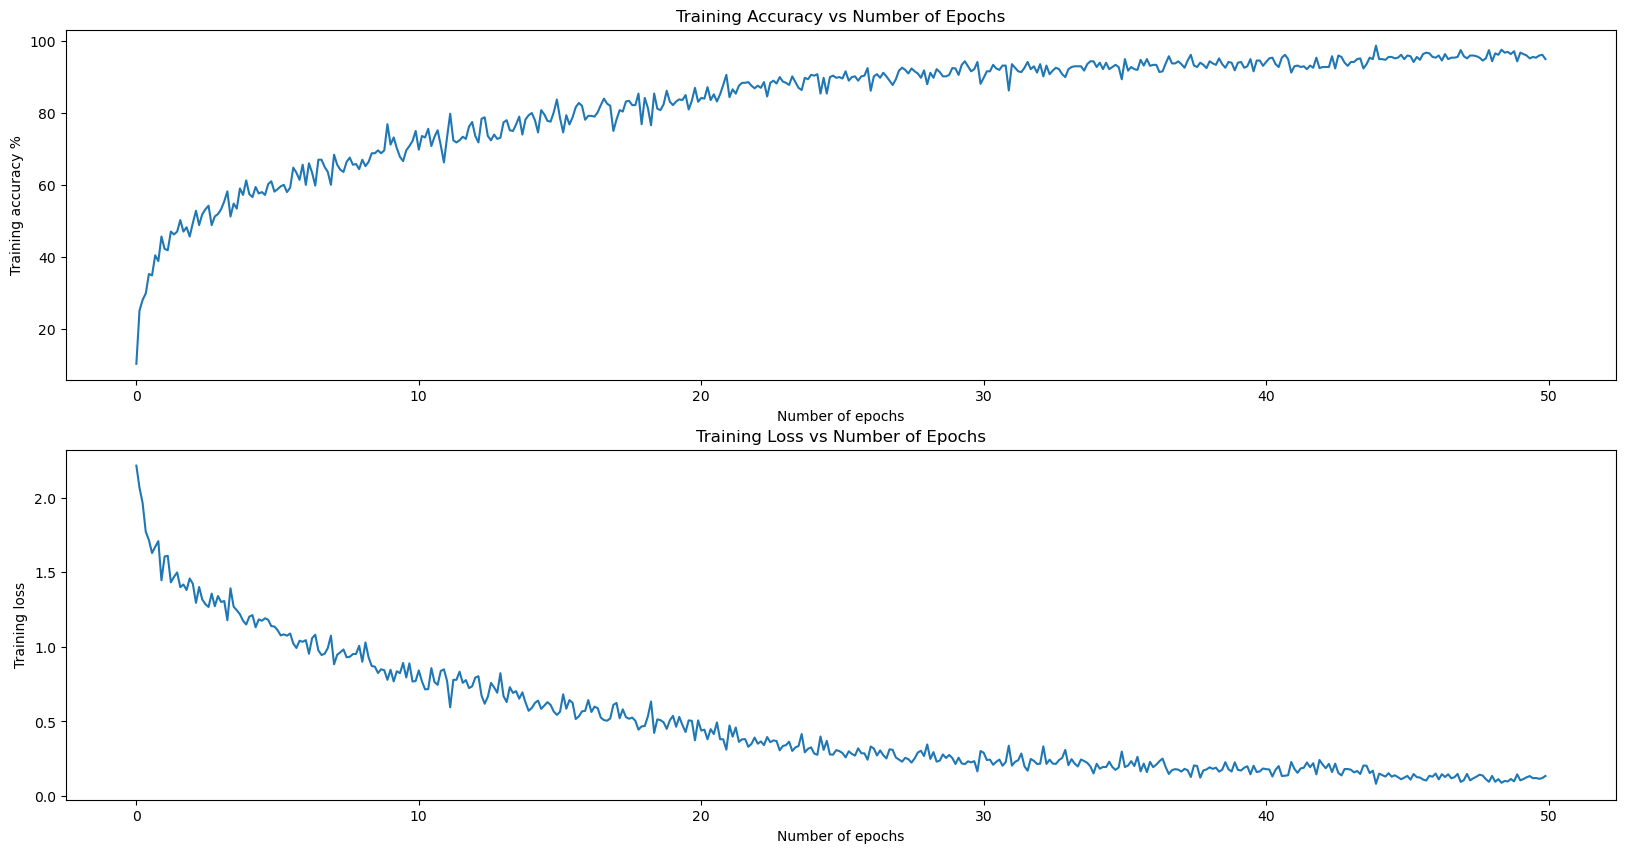

In [17]:
#plot_training_metrics(pd.read_pickle("metric/CustomCNN-metric.pkl"))

-- TEST SET METRICS --
Accuracy: 73.600%
F-score: 0.780
Recall: 0.896
Precision: 0.765
Confusion matrix


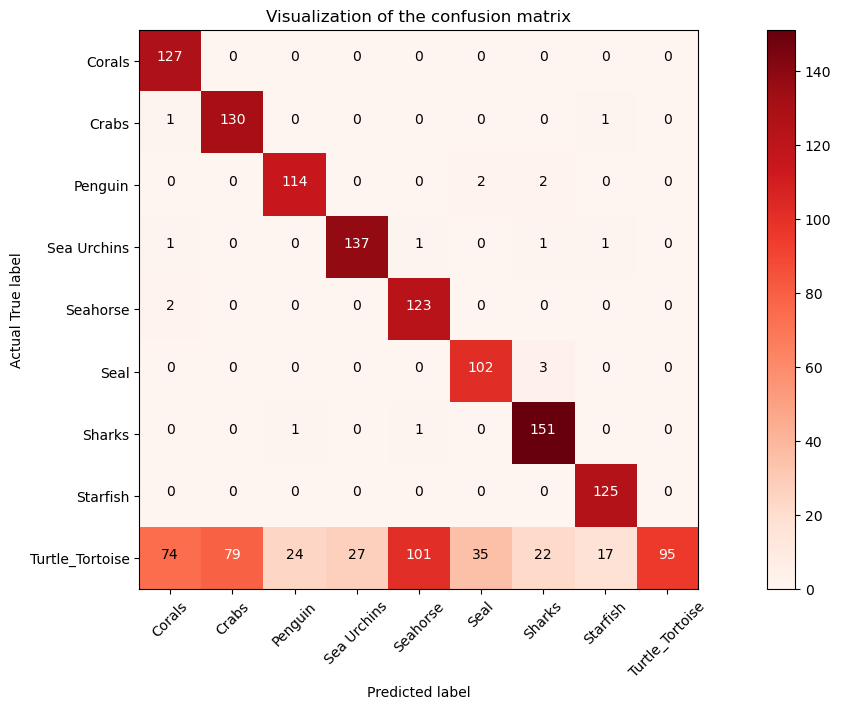

In [14]:
#run_testing('CustomCNN')

### HOG (Histogram of Gradients) with SVM

A class of sea animals vary so much in color. Structural cues like shape may give a more robust representation. Gradients of specific directions captures some notion of shape. To allow for some variability in shape, we’ll use features known as Histogram of Oriented Gradients (HOG).

The idea of HOG is instead of using each individual gradient direction of each individual pixel of an image, we group the pixels into small cells. For each cell, we compute all the gradient directions and group them into a number of orientation bins. We sum up the gradient magnitude in each sample. So stronger gradients contribute more weight to their bins, and effects of small random orientations due to noise is reduced. This histogram gives us a picture of the dominant orientation of that cell. Doing this for all cells gives us a representation of the structure of the image. The HOG features keep the representation of an object distinct but also allow for some variations in shape.

### Classifier
We use multiclass support vector machines as our classifier. The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

### Steps for training

- Extract HOG features from training and test images
- Use Multiclass SVM to train model to classify the HOG features
- Test the model using test set


In [15]:
from skimage.feature import hog
import imageio
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score
import _pickle as pickle
from skimage.feature import match_descriptors, plot_matches, SIFT
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

### Method to extract HOG features

In [20]:
def create_features_dataset(train=True,loader=None):
    train_test = "train"
    if(not train):
        train_test="test"

    hog_features=[]
    hog_images=[]
    landmarks=[]
    labels_list=[]
    for i, (images, labels) in enumerate(loader):
        for i in (range(len(labels.numpy()))):
            img = images.numpy()[i,1]
            labels_list.append(labels.numpy()[i])
            features, hog_image = hog(img, orientations=9, pixels_per_cell=(6, 6),
                                      cells_per_block=(3, 3), visualize=True)
            hog_features.append(features)
            hog_images.append(hog_image)
            
    np.save(f'data/hog_features_{train_test}.npy',hog_features)
    np.save(f'data/labels_{train_test}.npy',labels_list)
    np.save(f'data/hog_images_{train_test}.npy',hog_images)
            
    print(f'Hog Features created in data/hog_features{train_test}.npy')
    print(f'Hog Images created in data/hog_images_{train_test}.npy')
    print(f'Labels created in data/labels_{train_test}.npy')

In [16]:
#create_features_dataset(train=True,loader=train_sampled_dataloader)
#create_features_dataset(train=False,loader=test_set_loader)

### Visualizing HOG Images

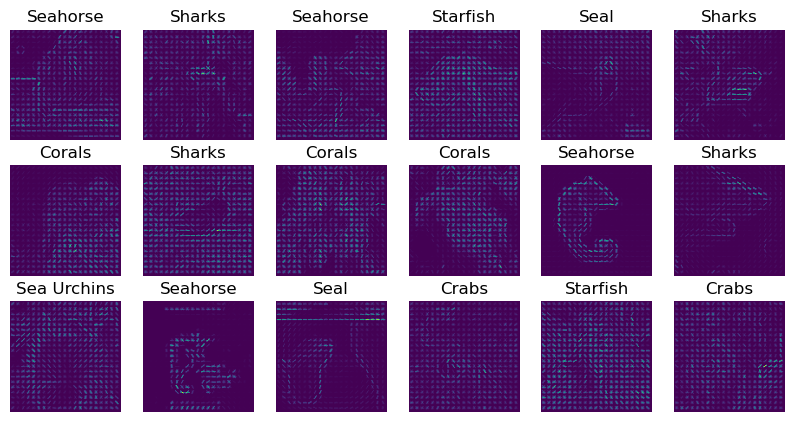

In [66]:
def visualize_hog_images(n_row=10,n_col=10):
    
    dict={0:'Corals',1:'Crabs',2:'Penguin',3:'Sea Urchins',4:'Seahorse',5:'Seal',6:'Sharks',7:'Starfish',8:'Turtle_Tortoise'}
    
    plt.figure(figsize=(10,5)) 
    hog_img = np.load("data/hog_images_train.npy",allow_pickle=True)
    hog_labels = np.load("data/labels_train.npy",allow_pickle=True)
    for i in range(n_row*n_col):
        plt.subplot(n_row,n_col,i+1)
        plt.title(dict[hog_labels[i]])
        plt.imshow(hog_img[i])
        plt.axis('off')

visualize_hog_images(n_row=3,n_col=6)

### Method to load, train and evaluate data

In [31]:
def load_data(hog_features_f,labels):
    data_dict = dict()
    
    data_dict['X'] = np.load(hog_features_f)
    data_dict['Y'] = np.load(labels)
    
    return data_dict

def evaluate(model, X, Y):
        predicted_Y = model.predict(X)
        accuracy = accuracy_score(Y, predicted_Y)
        return accuracy

def train_SVC(data,epochs,random_state,kernel,decision_function,gamma):
    
    model = SVC(random_state=random_state, max_iter=epochs, kernel=kernel, decision_function_shape=decision_function, gamma=gamma)

    print( "start training...")
    print( "--")
    print( "kernel: {}".format(kernel))
    print( "decision function: {} ".format(decision_function))
    print( "max epochs: {} ".format(epochs))
    print( "gamma: {} ".format(gamma))
    print( "--")
    print( "Training samples: {}".format(len(data['Y'])))
    
    model.fit(data['X'], data['Y'])

    with open("models/svm.bin", 'wb') as f:
        pickle.dump(model, f)


    print( "calculating accuracy...")
    accuracy = evaluate(model, data['X'], data['Y'])
    print( "accuracy = {0:.1f}".format(accuracy*100))
    return accuracy


def run_svm_testing(test):
    
    targets = test['Y']
    
    with open("models/svm.bin", 'rb') as f:
        model = pickle.load(f)
    
    predictions = model.predict(test['X'])
     
    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    
    pretty_print_metrics([accuracy,f1,recall,precision])
    plot_cm(np.array(conf_matrix), CLASSES)
    

In [23]:
train_dict = load_data("data/hog_features_train.npy","data/labels_train.npy")
test_dict = load_data("data/hog_features_test.npy","data/labels_test.npy")

In [24]:
epochs = 1000
random_state = 0
kernel = 'rbf'
decision_function = 'ovr'
gamma = 0.001

#train_SVC(train_dict,epochs=epochs,random_state=random_state,kernel=kernel,decision_function=decision_function,gamma=gamma)

start training...
--
kernel: rbf
decision function: ovr 
max epochs: 1000 
gamma: 0.001 
--
Training samples: 4160
calculating accuracy...
accuracy = 81.8


0.8180288461538462

C:\Users\kshit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-- TEST SET METRICS --
Accuracy: 46.333%
F-score: 0.492
Recall: 0.595
Precision: 0.437
Confusion matrix


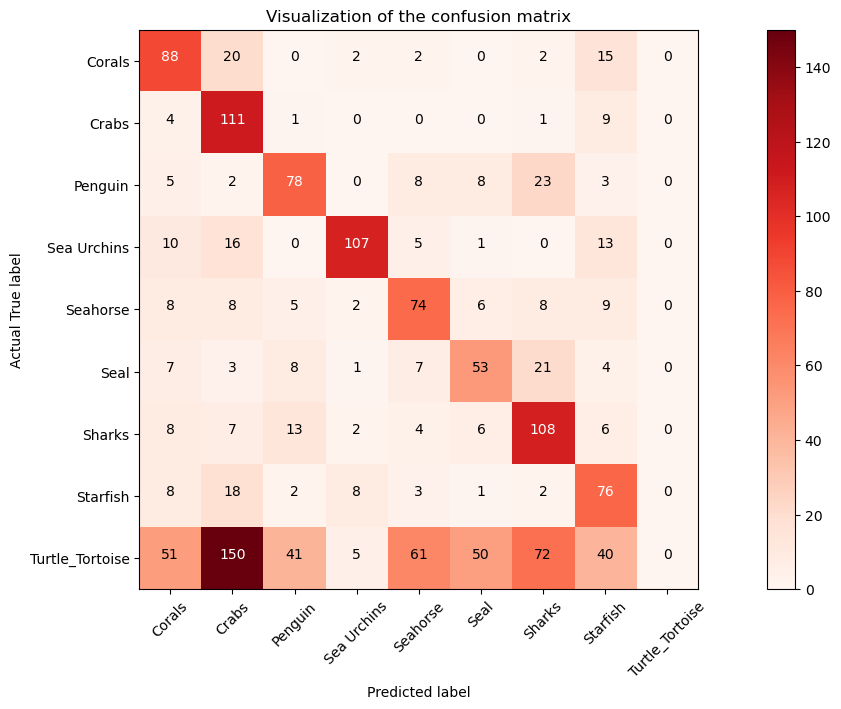

In [32]:
run_svm_testing(test_dict)

### SIFT with SVM Bag of visual words

### Scale Invariant Feature Transform (SIFT)

SIFT is a feature extraction method that reduces the image content to a set of points used to detect similar patterns in other images. This algorithm is usually related to computer vision applications, including image matching and object detection. 

### Classifier
We use multiclass support vector machines as our classifier to classify SIFT features. The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

### Steps to training algorithm

- Extract SIFT features from train and test images.
- Quantize the feature space. Kmeans algorithm is used for clustering the SIFT features and the center points, we get from the clustering algorithm, are our visual words.
- Extract local features and compare these features with visual words to create histograms for each image both for the test and train dataset.
- Predict the class of test images comparing with each histogram of train images. We will used multiclass SVM for this task.
- Evaluate performance metrics.


### Methods to extract SIFT features and create Histogram from bag of words

In [24]:
def extract_SIFT_features(loader=None,train=True):
    
    train_test = "train"
    if(not train):
        train_test="test"
    
    descriptor_extractor = SIFT()
    
    image_descriptors = []
    
    for i, (images, labels) in enumerate(loader):
        for i in (range(len(labels.numpy()))):
            img = images.numpy()[i,1]
            descriptor_extractor.detect_and_extract(img)
            image_descriptors.append(descriptor_extractor.descriptors)
    
    np.save(f'data/sift_features_{train_test}.npy',image_descriptors)
    
    print(f'SIFT Features created in data/sift_features_{train_test}.npy')

#method to create bag of visual words using k-means algorithm
def kmean_bow(all_descriptors, num_cluster):
    bow_dict = []

    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_
    
    with open("models/bow_kmeans.bin", 'wb') as f:
        pickle.dump(bow_dict, f)
    
    print('Bag of wrods created')

    return bow_dict

#method to create histogram from local features by mathcing with bag of words. 
#Euclidiean distance is used to measure the similarity.
def create_feature_bow(image_descriptors, BoW, num_cluster,train):
    
    train_test = "train"
    if(not train):
        train_test="test"
    
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)

            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1
        X_features.append(features)
        
    np.save(f'data/sift_hist_features_{train_test}.npy',X_features)
    
    print(f'SIFT Hist Features created in data/sift_hist_features_{train_test}.npy')

    return X_features

In [13]:
#extract_SIFT_features(loader=train_sampled_dataloader,train=True)
#extract_SIFT_features(loader=test_set_loader,train=False)

SIFT Features created in data/sift_featurestest.npy


### Creating Bag of visual words

In [25]:
image_descriptors = np.load("data/sift_features_train.npy",allow_pickle=True)
all_descriptors = []
#for descriptor in image_descriptors:
#    if descriptor is not None:
#        for des in descriptor:
#            all_descriptors.append(des)

num_cluster = 100
#BoW = kmean_bow(all_descriptors, num_cluster)

C:\Users\kshit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Bag of wrods created


### Creating Histogram from Bag of visual words

In [36]:
image_test_descriptors = np.load("data/sift_features_test.npy",allow_pickle=True)
#X_features = create_feature_bow(image_descriptors, BoW, num_cluster,True)
#X_test_features = create_feature_bow(image_test_descriptors, BoW, num_cluster,False)

SIFT Hist Features created in data/sift_hist_features_train.npy
SIFT Hist Features created in data/sift_hist_features_test.npy


In [36]:
train_dict = load_data("data/hog_features_train.npy","data/labels_train.npy")
test_dict = load_data("data/hog_features_test.npy","data/labels_test.npy")

### Training SVM with SIFT

In [49]:
model_svm = SVC(C = 30, max_iter=1000, random_state = 0)

In [50]:
#model_svm.fit(np.load("data/sift_hist_features_train.npy"), train_dict['Y'])
#with open("models/bow_svm_kmeans.bin", 'wb') as f:
    #pickle.dump(model_svm, f)

C:\Users\kshit\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Testing SVM model trained with SIFT

-- TEST SET METRICS --
Accuracy: 9.667%
F-score: 0.101
Recall: 0.120
Precision: 0.125
Confusion matrix


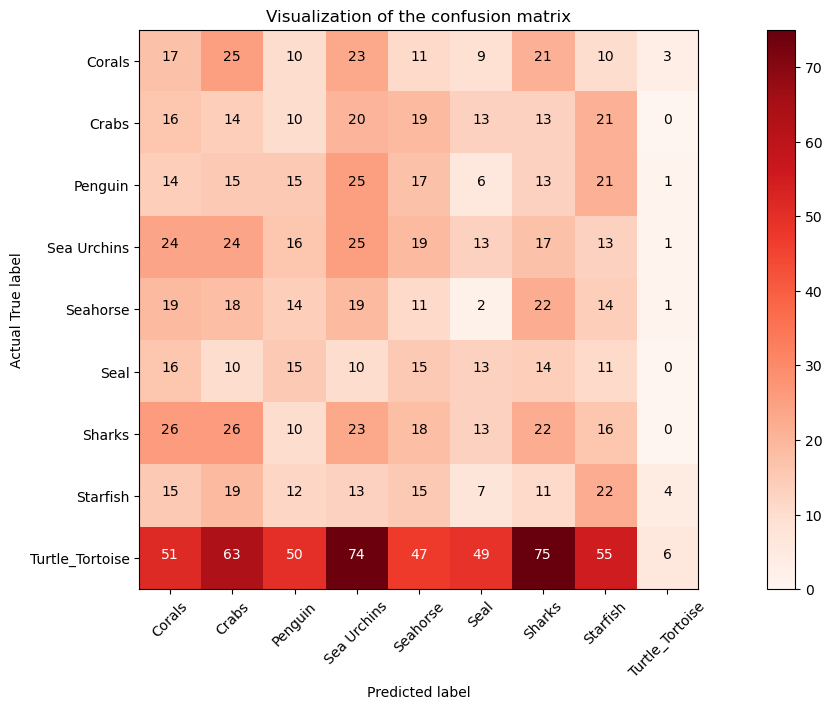

In [39]:
def run_bow_svm_test(test_features,test_labels):
     
    with open("models/bow_svm_kmeans.bin", 'rb') as f:
        model = pickle.load(f)
        
    targets=test_labels
    predictions = model.predict(test_features)
     
    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    
    pretty_print_metrics([accuracy,f1,recall,precision])
    plot_cm(np.array(conf_matrix), CLASSES)
        
run_bow_svm_test(np.load("data/sift_hist_features_test.npy"),test_dict['Y'])

## Results and Conclusion

We have trained total four models with 4 different approaches:

- Using Pre-trained models
- Using our own CNN architecture
- Using HOG features with SVM
- Using SIFT features with SVM

Following are the experimental results given in the table below:

### Experimental Results

| Model/Metric | Accuracy | F-Socre | Recall | Precision |
| --- | --- | --- | --- | --- |
| ResNet50(Pretrained) | 64.400 | 0.692 | 0.844 | 0.595 |
| Custom-CNN | 73.600 | 0.780 | 0.896 | 0.765 |
| SVM with HOG features | 46.333 | 0.492 | 0.595 | 0.437 |
| SVM with SIFT features | 9.667 | 0.101 | 0.120 | 0.125 |

#### Interpreting Results

From the results we can observe that the Custom-CNN model achieves highest accuracy on test dataset followed by the pretrained model. Models trained using HOG and SIFT features does not perform well. The Custom-CNN trains on the training data from beginning and the layers learn the data from scratch therefore it is able to predict the data more accurately. The resnet50 model is pre-trained on ImageNet dataset which contains natural images. Therefore the resnet50 model tries to correlate with the knowledge it gained from ImageNet dataset to the sea animals dataset. The resnet model is able to classify most of the classes correctly except the turtle class. The custom CNN model is able to classify turtle class better. However models trained using hand crafted features like HOG and SIFT fails to classify most of the classes correctly. If we analyze the HOG images we can see that the HOG images of corals and turtle is similar and most of the images are similar so the model is not able to accurately classify most of the images. SVM with SIFT feature model fails with the least accuracy becuase most of the images contain water and the colors are similar in most of the images therefore there are no distinction between SIFT features among classes and therefore model is unable to classify correctly.   

### Conclusion

In conclusion we can say that Deep CNN architecture are better suited for image classification problems on natural images than training on extracted features like HOG and SIFT. Deep CNN architectures are very powerful in predicting images if the number of training samples are large. However extracted features are useful if the number of training data is small and it is easy to distinguish shapes in the images. Therefore deep learning models are able to generalize better for real world problems than hand crafted features.  

### References

[1] https://github.com/myconcordia/COMP478 

[2] Z. Cao, J. C. Principe, B. Ouyang, F. Dalgleish and A. Vuorenkoski, "Marine animal classification using combined CNN and hand-designed image features," OCEANS 2015 - MTS/IEEE Washington, Washington, DC, USA, 2015, pp. 1-6, doi: 10.23919/OCEANS.2015.7404375. 

[3] N. N, A. Siva Kumaran K, A. A, A. V. S and B. M. J, "Convolutional Neural Networks (CNN) based Marine Species Identification," 2022 International Conference on Automation, Computing and Renewable Systems (ICACRS), Pudukkottai, India, 2022, pp. 602-607, doi: 10.1109/ICACRS55517.2022.10029109.

[4] N. N, A. Siva Kumaran K, A. A, A. V. S and B. M. J, "Convolutional Neural Networks (CNN) based Marine Species Identification," 2022 International Conference on Automation, Computing and Renewable Systems (ICACRS), Pudukkottai, India, 2022, pp. 602-607, doi: 10.1109/ICACRS55517.2022.10029109. 

[5] X. Li and X. Guo, "A HOG Feature and SVM Based Method for Forward Vehicle Detection with Single Camera," 2013 5th International Conference on Intelligent Human-Machine Systems and Cybernetics, Hangzhou, China, 2013, pp. 263-266, doi: 10.1109/IHMSC.2013.69.

[6] A. P. Puspaningrum et al., "Waste Classification Using Support Vector Machine with SIFT-PCA Feature Extraction," 2020 4th International Conference on Informatics and Computational Sciences (ICICoS), Semarang, Indonesia, 2020, pp. 1-6, doi: 10.1109/ICICoS51170.2020.9298982.

[7] Q. Li and X. Wang, "Image Classification Based on SIFT and SVM," 2018 IEEE/ACIS 17th International Conference on Computer and Information Science (ICIS), Singapore, 2018, pp. 762-765, doi: 10.1109/ICIS.2018.8466432.